In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/GitHub/dynamics-simulation-16-715/lecture-notebooks/Lecture 21/Project.toml`


In [26]:
using LinearAlgebra
using ForwardDiff
using Plots
using Ipopt
using MathOptInterface
const MOI = MathOptInterface

MathOptInterface

In [27]:
#Parameters
g = 9.81
m = 1.0
h = 0.05 #20 Hz
Tf = 1.5 #final time (sec)
thist = Array(0:h:Tf)
N = length(thist)

31

In [28]:
#Initial Conditions
q0 = [0; 3.0]
v0 = [1.0; 0.0]
q1 = q0 + h*v0 + 0.5*h*h*[0; -g]

2-element Vector{Float64}:
 0.05
 2.9877375

In [29]:
#Signed-distance function for a particle in 2D
function ϕ(q)
    return q[2]
end

Dϕ = [0; 1.0]'

1×2 adjoint(::Vector{Float64}) with eltype Float64:
 0.0  1.0

In [30]:
#Discrete Lagrangian stuff
function L(q,q̇)
    0.5*m*q̇'*q̇ - m*g*q[2]
end

function Ld(q1,q2)
    qm = 0.5*(q1 + q2)
    vm = (q2-q1)/h
    return L(qm,vm)
end

function D1Ld(q1,q2)
    return ForwardDiff.gradient(dq1->Ld(dq1,q2),q1)
end

function D2Ld(q1,q2)
    return ForwardDiff.gradient(dq2->Ld(q1,dq2),q2)
end

D2Ld (generic function with 1 method)

In [31]:
function DEL(q1,q2,q3,n)
    D2Ld(q1,q2) + D1Ld(q2,q3) + h*Dϕ'*n
end

DEL (generic function with 2 methods)

In [32]:
#Boilerplate setup code to interface with IPOPT.

struct ProblemMOI <: MOI.AbstractNLPEvaluator
    n_nlp::Int
    m_nlp::Int
    idx_ineq
    obj_grad::Bool
    con_jac::Bool
    sparsity_jac
    sparsity_hess
    primal_bounds
    constraint_bounds
    hessian_lagrangian::Bool
end

function ProblemMOI(n_nlp,m_nlp;
        idx_ineq=(1:0),
        obj_grad=true,
        con_jac=true,
        sparsity_jac=sparsity_jacobian(n_nlp,m_nlp),
        sparsity_hess=sparsity_hessian(n_nlp,m_nlp),
        primal_bounds=primal_bounds(n_nlp),
        constraint_bounds=constraint_bounds(m_nlp,idx_ineq=idx_ineq),
        hessian_lagrangian=false)

    ProblemMOI(n_nlp,m_nlp,
        idx_ineq,
        obj_grad,
        con_jac,
        sparsity_jac,
        sparsity_hess,
        primal_bounds,
        constraint_bounds,
        hessian_lagrangian)
end

function constraint_bounds(m; idx_ineq=(1:0))
    c_l = zeros(m)

    c_u = zeros(m)
    c_u[idx_ineq] .= Inf
    
    return c_l, c_u
end

function row_col!(row,col,r,c)
    for cc in c
        for rr in r
            push!(row,convert(Int,rr))
            push!(col,convert(Int,cc))
        end
    end
    return row, col
end

function sparsity_jacobian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function sparsity_hessian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function MOI.eval_objective(prob::MOI.AbstractNLPEvaluator, x)
    objective(x)
end

function MOI.eval_objective_gradient(prob::MOI.AbstractNLPEvaluator, grad_f, x)
    ForwardDiff.gradient!(grad_f,objective,x)
    return nothing
end

function MOI.eval_constraint(prob::MOI.AbstractNLPEvaluator,g,x)
    constraint!(g,x)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::MOI.AbstractNLPEvaluator, jac, x)
    ForwardDiff.jacobian!(reshape(jac,prob.m_nlp,prob.n_nlp), constraint!, zeros(prob.m_nlp), x)
    return nothing
end

function MOI.features_available(prob::MOI.AbstractNLPEvaluator)
    return [:Grad, :Jac]
end

MOI.initialize(prob::MOI.AbstractNLPEvaluator, features) = nothing
MOI.jacobian_structure(prob::MOI.AbstractNLPEvaluator) = prob.sparsity_jac

function ipopt_solve(x0,prob::MOI.AbstractNLPEvaluator;
        tol=1.0e-6,c_tol=1.0e-6,max_iter=10000)
    x_l, x_u = prob.primal_bounds
    c_l, c_u = prob.constraint_bounds

    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    block_data = MOI.NLPBlockData(nlp_bounds,prob,true)

    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol
    
    #Uncomment the following line to turn off verbose IPOPT output
    solver.options["print_level"] = 0

    x = MOI.add_variables(solver,prob.n_nlp)

    for i = 1:prob.n_nlp
        xi = MOI.SingleVariable(x[i])
        MOI.add_constraint(solver, xi, MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, xi, MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res
end

ipopt_solve (generic function with 1 method)

In [33]:
#Objective and constraint functions for IPOPT

function objective(z)
    qn = z[1:2]
    n = z[3]
    s = z[4]
    
    return s #Minimize slacks associated with relaxed complementarity condition
end

function constraint!(c,z)
    qn = z[1:2]
    n = z[3]
    s = z[4]
    
    c .= [DEL(qhist[:,k-1],qhist[:,k],qn,n); #DEL
          ϕ(qn); #signed distance
          s-n*ϕ(qn)] #relaxed complementarity
    
    return nothing
end

#Specify the indecies of c (constraint output) that should be non-negative.
#The rest will be treated as equality constraints.
nonnegative_constraint_indices = (3:4)

function primal_bounds(n)
    #Enforce simple bound constraints on the decision variables (e.g. positivity) here
    
    x_l = [-Inf*ones(2); zeros(2)]
    x_u = Inf*ones(4)
    
    return x_l, x_u
end

primal_bounds (generic function with 1 method)

In [34]:
#Solve with IPOPT
n_nlp = 4
m_nlp = 4
nlp_prob = ProblemMOI(n_nlp,m_nlp, idx_ineq=nonnegative_constraint_indices);

#Initial conditions
qhist = zeros(2,N)
qhist[:,1] .= q0
qhist[:,2] .= q1

nhist = zeros(N-1)
shist = zeros(N-1)
k = 0

for kk = 2:(N-1)
    k = kk
    z_guess = [qhist[:,k]; 0; 1.0]
    z_sol = ipopt_solve(z_guess,nlp_prob);
    qhist[:,k+1] .= z_sol[1:2]
    nhist[k] = z_sol[3]
    shist[k] = z_sol[4]
end

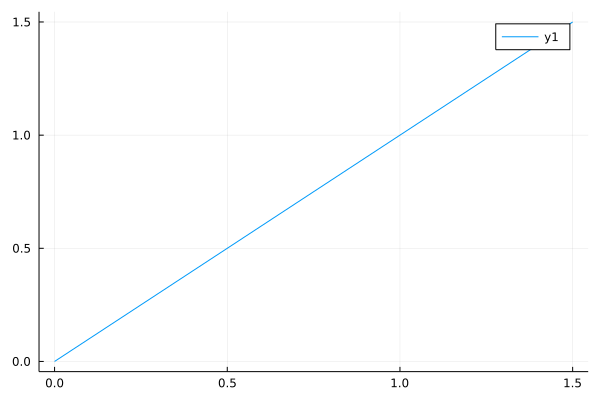

In [35]:
plot(thist,qhist[1,:])

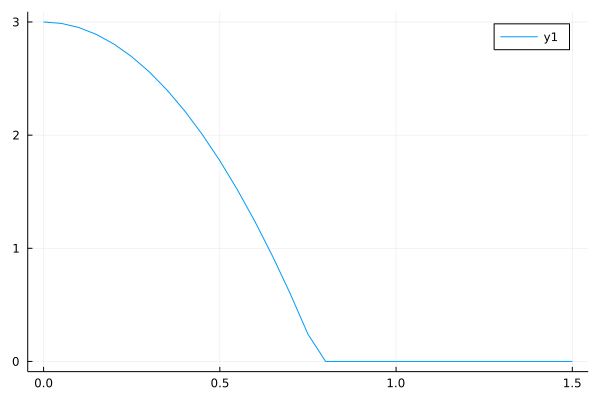

In [36]:
plot(thist,qhist[2,:])

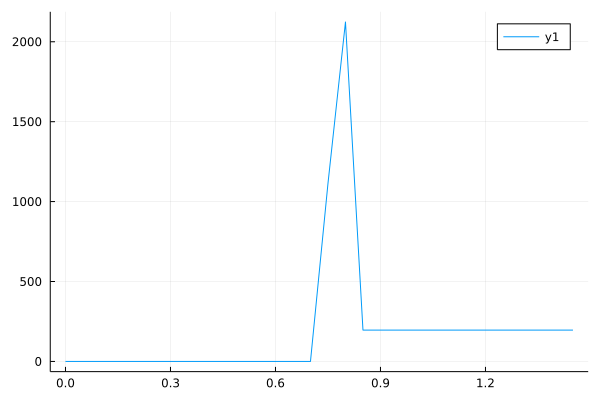

In [37]:
plot(thist[1:end-1],nhist)

In [38]:
maximum(shist)

8.219257315970218e-7